In [1]:

import pickle
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
id = 45578
df = fetch_openml( data_id=id)['frame']
df.shape

(20640, 9)

# Checking target distribution

- Target values are equally distributed, no class imbalance.

In [3]:
df['medianHouseValue'].value_counts(normalize=True)

medianHouseValue
False    0.500145
True     0.499855
Name: proportion, dtype: float64

# Data Preparation and Cleaning

In [4]:

df['medianHouseValue'] = np.where(df['medianHouseValue']=="True", 1, 0)

In [5]:
def check_nulls_and_types(df):
    nulls_df = (df.isnull().sum()/ df.shape[0]*100).round(2).to_frame().rename(columns={0:'percentage_nulls'})
    types_df = df.dtypes.to_frame().rename(columns={0:'data_type'})
    rv = nulls_df.merge(types_df, left_index=True, right_index=True)
    return rv

check_nulls_and_types(df)

,percentage_nulls,data_type
longitude,0.0,float64
latitude,0.0,float64
housingMedianAge,0.0,float64
totalRooms,0.0,float64
totalBedrooms,0.0,float64
population,0.0,float64
households,0.0,float64
medianIncome,0.0,float64
medianHouseValue,0.0,int64


# Train/Validation/Test Split

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=40)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=40)
print(len(df_train), len(df_val), len(df_test))
# Keep train copy for charts
df_train_c = df_train.copy()

12384 4128 4128


In [7]:
target = "medianHouseValue"

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

# Correlations Numerical Vars

- The correlation analysis shows that the following features have the stronges correlation with the target in the training data:

    - medianIncome
    - latitude
    - longitude
    - totalRooms
    - households
    - housingMedianAge

In [8]:
# Class seems Balanced
pd.Series(y_train).value_counts()

0    6245
1    6139
Name: count, dtype: int64

In [9]:
def correlation_w_target(df):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True,  fmt='.2f')
    # Adding title and labels
    plt.title("Correlations", fontsize=16)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.tight_layout() 
    plt.show()

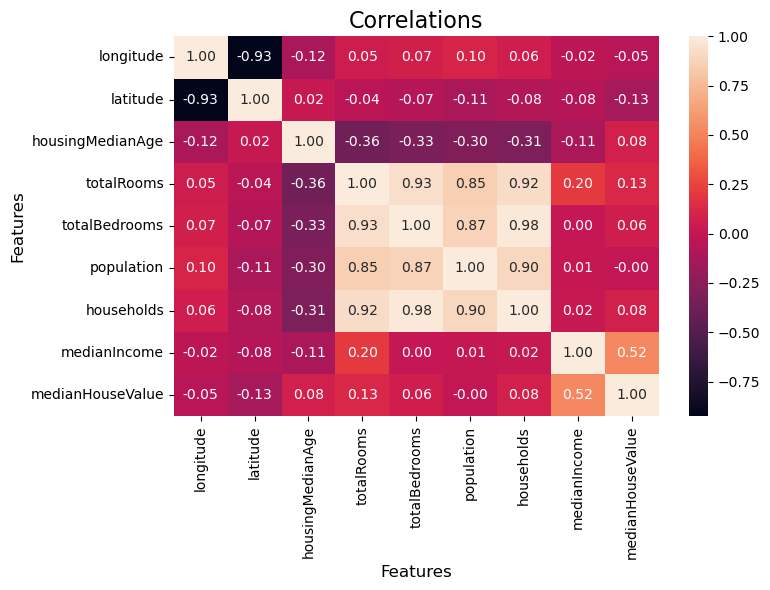

In [10]:
correlation_w_target(df_train_c)

In [11]:
def identify_top_k_w_target(df, k):
    target = "medianHouseValue"
    corr_matrix = df.corr()
    corr_matrix = corr_matrix[[target]].reset_index().rename(columns={"index":"features"})
    corr_matrix["abs_value"] = corr_matrix[target].abs()
    corr_matrix = corr_matrix.query("features!=@target")
    return corr_matrix.sort_values("abs_value", ascending=False).head(k).reset_index(drop=True)

In [12]:
top_k_features = identify_top_k_w_target(df_train_c, 5)
top_k_features

,features,medianHouseValue,abs_value
0,medianIncome,0.523322,0.523322
1,latitude,-0.133488,0.133488
2,totalRooms,0.126374,0.126374
3,households,0.082105,0.082105
4,housingMedianAge,0.077805,0.077805


# Zoom-In: Top 5 Features

- The boxplots for the top 5 numerical features in terms of correlation with the target variable show:

    - A different distribution in `medianIncome`. Instances where target value equal to zero have a lower median income and less variation compared to instances where the target equals 1.

    - There is a large overlap in the distribution for `latitude`. However, the median latitude is lower for instances where the target value equals 1 compared to instances where it is equal to 0.

    - Both `longitude` and `households` show a large number of outliers. Despite this, in both cases the median value is larger for instances where the target equals 1.

    - `MedianHouseAge` is slightly larger for values of the target equal to 1. Aside from this, it seems that the distributions show a similar behavior.

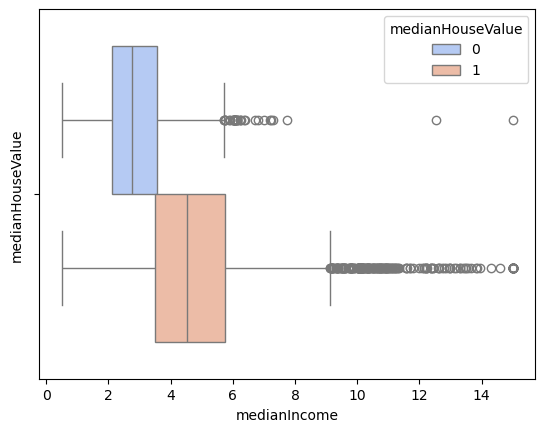

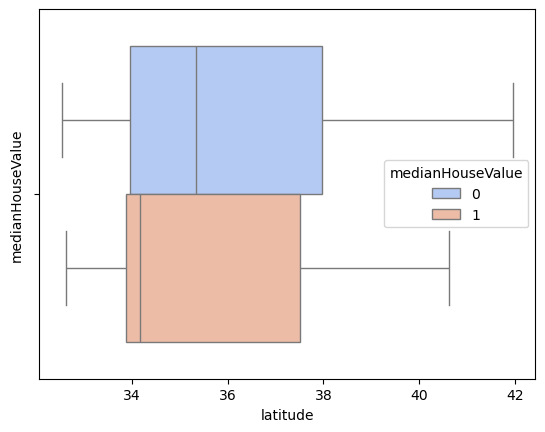

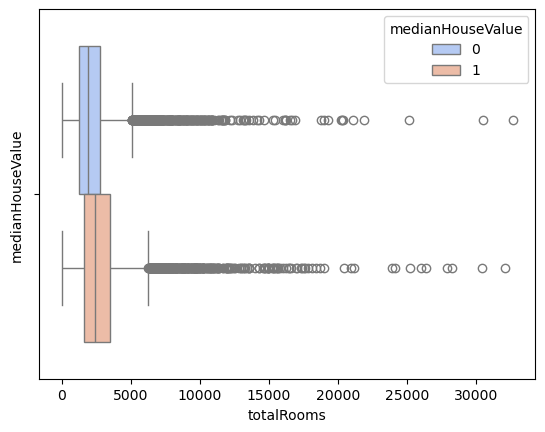

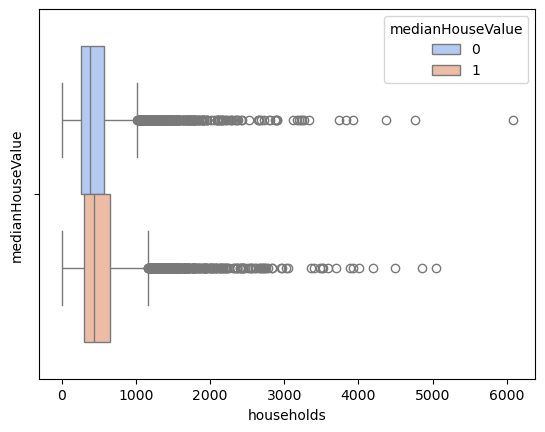

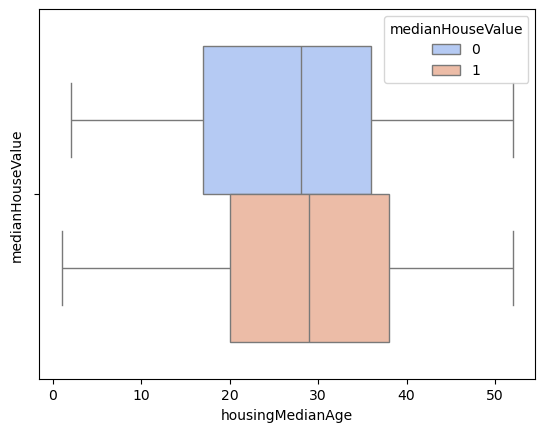

In [13]:

for col in top_k_features['features']:
    palette = sns.color_palette("Set2")
    sns.boxplot(data=df_train_c, x=col, hue="medianHouseValue", palette='coolwarm')
    plt.xlabel(col)
    plt.ylabel('medianHouseValue')
    #plt.title(f'Distribution of Poisonous vs. Edible by {col}')
    plt.show()

# Model Selection

- I will use `roc_auc_score` as a metric to compare different models

- The baseline model will be Logistic Regression where we will tune the inverse of regularization strength (C).

- The challenger model will be RandomForestClassifier, where we will tune three of its main hyperparameters: `n_estimators`, `max_depth` and `min_samples_leaf`.

In [14]:
# Use vectorizer for simplicity in inference despite having all numerical vars
def transform_data(df):
    dicts = df.to_dict(orient='records')
    dv = DictVectorizer(sparse=True)
    X = dv.fit_transform(dicts)
    return X, dv

In [15]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [16]:
X_train, dv = transform_data(df_train)

# 1. Logistic Regression

In [17]:
scores = []
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=40)
    model.fit(X_train, y_train)
    y_pred = predict(df_val, dv,  model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((C, auc))

In [18]:
df_logistic_scores = pd.DataFrame(scores, columns=["C", 'auc'])
df_logistic_scores

,C,auc
0,0.01,0.885833
1,0.10,0.885897
2,1.00,0.885964
3,10.00,0.886188
4,100.00,0.885956


In [19]:
# Max AUC
df_logistic_scores.iloc[df_logistic_scores['auc'].idxmax()]

C      10.000000
auc     0.886188
Name: 3, dtype: float64

# 2. Random Forest

In [20]:
X_val = dv.transform(df_val.to_dict(orient='records'))
scores = []

for n in range(10, 150, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [21]:
df_scores_hp1 = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

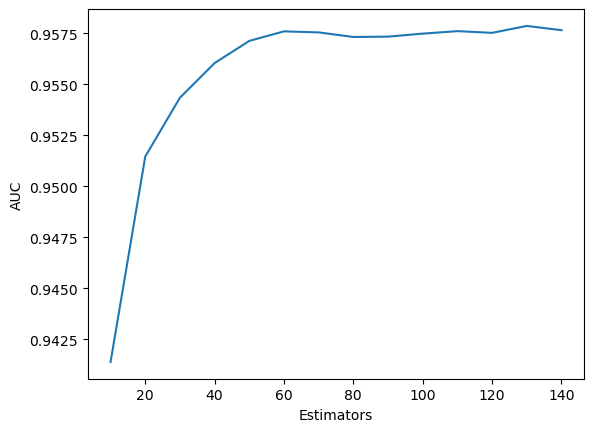

In [24]:
plt.plot(df_scores_hp1.n_estimators, df_scores_hp1.auc)
plt.xlabel('Estimators')
plt.ylabel('AUC')
plt.show()

In [25]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 150, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=42, 
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [26]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores_hp2 = pd.DataFrame(scores, columns=columns)

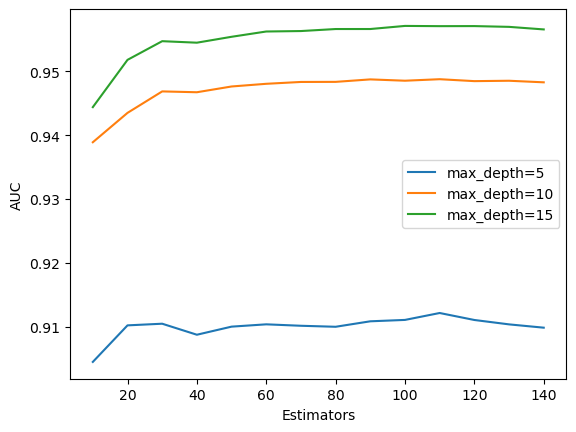

In [27]:
for d in [5, 10, 15]:
    df_subset = df_scores_hp2[df_scores_hp2.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)
    plt.ylabel('AUC')
    plt.xlabel("Estimators")

plt.legend()
plt.show()

In [28]:
max_depth = 15
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 150, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=42,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))


In [29]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores_hp3 = pd.DataFrame(scores, columns=columns)

In [30]:
df_scores_hp3.iloc[df_scores_hp3['auc'].idxmax()]

min_samples_leaf      1.000000
n_estimators        100.000000
auc                   0.957139
Name: 9, dtype: float64

# Feature Importance for Top Model

- From the results above, we can observe that the `RandomForestClassifier` outperformed the `LogisticRegression` model in terms of auc: 0.957 vs. 0.886.

- Looking at the top features in the final (i.e., best hyperparameters) `RandomForestClasssifier`, we can observe that they show a close relationship to our correlation analysis.

In [31]:
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=1, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9571387823661774

In [32]:
feats = {} 
for feature, importance in zip(dv.feature_names_, rf.feature_importances_):
    feats[feature] = importance 
importances_df = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'gain'}).reset_index().rename(columns={'index':'features'})

In [33]:
top_k_features = importances_df.sort_values('gain',
                        ascending=False,
                        ).head(10).reset_index(drop=True)
top_k_features

,features,gain
0,medianIncome,0.317749
1,longitude,0.181721
2,latitude,0.178660
3,population,0.079795
4,totalRooms,0.071012
5,households,0.057349
6,totalBedrooms,0.056962
7,housingMedianAge,0.056752


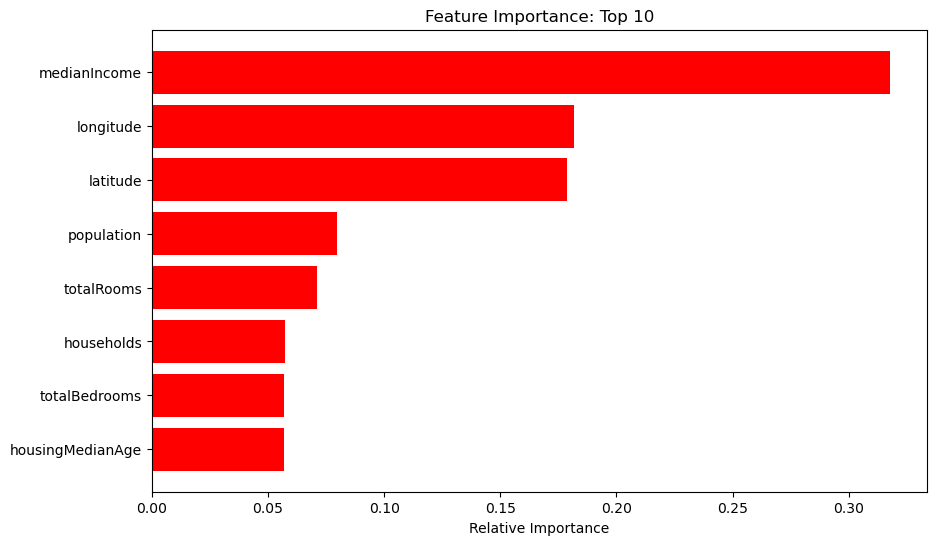

In [34]:
# Code adapted from https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
features = top_k_features['features']
importances = top_k_features["gain"]
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importance: Top 10')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


# Final Model

- The above analysis showed that the best hyperparameters (for the subset of hyperparemeters we chose) for the RandomForestClassifier are:

- n_estimators=100, max_depth=15, min_samples_leaf=1

- The auc in the test set is consistent with the results we found during validation: test (0.956), val (0.957)

In [35]:
params = {"n_estimators":100,
          "max_depth":15,
          "min_samples_leaf":1,
          "random_state":42, 
          "n_jobs":-1}

target = "medianHouseValue"
y_full = df_full_train[target].values
del df_full_train[target]
X_full, dv = transform_data(df_full_train)

model = RandomForestClassifier(**params)
model.fit(X_full, y_full)
y_pred = predict(df_test, dv, model)
roc_auc_score(y_test, y_pred)


0.9558028340637037